### Load the model

In [1]:
from transformers import LayoutLMv2ImageProcessor, LayoutXLMTokenizer
from transformers import LayoutLMv2Model

image_processor = LayoutLMv2ImageProcessor(apply_ocr=True)
tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")

# Load the pre-trained model without classification head
model = LayoutLMv2Model.from_pretrained("microsoft/layoutxlm-base")

c:\Users\Habram\Anaconda3\envs\LayoutXLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2Model: ['layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_trac

### Load the classifier

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch

softmax = nn.Softmax(dim=1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 35)

    def forward(self, x):
        x = self.fc(x)
        return x

classifier = Net()
classifier.load_state_dict(torch.load(r'classifier.pt'))

<All keys matched successfully>

### Inference

In [3]:
import numpy as np

def group_subword_embeddings(tokens, embeddings, bboxes):
    groups = []
    current_group = []
    for idx, token in enumerate(tokens):
        # !Not an underscore! '_ ▁' but a special character
        if token.startswith('▁'):
            if len(current_group) > 0:
                groups.append(current_group)
            current_group = [idx]
        elif token == '<s>' or token == '</s>' or token == '<pad>':
            continue
        else:
            current_group.append(idx)
    groups.append(current_group)

    grouped_embeddings = []
    grouped_tokens = []
    grouped_bboxes = []
    for group in groups:
        grouped_tokens.append(''.join([tokens[i].lstrip('▁') for i in group]))
        grouped_embeddings.append(np.array(embeddings[group[0]: group[-1]+1].mean(axis=0)))
        grouped_bboxes.append(bboxes[group[0]])

    return grouped_tokens, np.array(grouped_embeddings), grouped_bboxes

##### Prepare the example for the model

In [4]:
from PIL import Image

invoice = Image.open(r'C:\Users\Habram\Documents\Datasets\IstVoices_de\testing_data\images\178.tif')
invoice = invoice.convert('RGB')

img_features = image_processor(invoice, return_tensors='pt')
image = img_features['pixel_values']
words = img_features['words'][0]
boxes = img_features['boxes'][0]

encoding = tokenizer(words, 
                     boxes=boxes,  
                     truncation=True, 
                     padding="max_length", 
                     max_length=512,
                     return_tensors='pt'
                     )

encoding['image'] = image

##### Perform the forward pass and get the embeddings

In [5]:
with torch.no_grad():
    output = model(**encoding, output_hidden_states=True)

# Get the output embeddings of the XLM model
xlm_embeddings = output['last_hidden_state'][0]

# Get the input IDs
input_ids = encoding["input_ids"]

# Convert the input IDs to sub-words
tokens = tokenizer.convert_ids_to_tokens(*input_ids)

# Group the sub-words and embeddings
joined_tokens, joined_embeddings, joinded_bboxes = group_subword_embeddings(tokens, xlm_embeddings, encoding["bbox"][0])

##### Perform the classification on the embeddings

In [6]:
predictions = classifier(torch.tensor(joined_embeddings))
predictions = softmax(predictions)
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.numpy()

##### Visualize the result

In [7]:
id2label = {0: 'O',
            1: 'B-R_NAME',
            2: 'I-R_NAME',
            3: 'B-R_STREET',
            4: 'I-R_STREET',
            5: 'B-R_HOUSENUMBER',
            6: 'I-R_HOUSENUMBER',
            7: 'B-R_ZIP',
            8: 'I-R_ZIP',
            9: 'B-R_CITY',
            10: 'I-R_CITY',
            11: 'B-R_COUNTRY',
            12: 'I-R_COUNTRY',
            13: 'B-S_NAME',
            14: 'I-S_NAME',
            15: 'B-S_STREET',
            16: 'I-S_STREET',
            17: 'B-S_HOUSENUMBER',
            18: 'I-S_HOUSENUMBER',
            19: 'B-S_ZIP',
            20: 'I-S_ZIP',
            21: 'B-S_CITY',
            22: 'I-S_CITY',
            23: 'B-S_COUNTRY',
            24: 'I-S_COUNTRY',
            25: 'B-S_BANK',
            26: 'I-S_BANK',
            27: 'B-S_IBAN',
            28: 'I-S_IBAN',
            29: 'B-I_NUMBER',
            30: 'I-I_NUMBER',
            31: 'B-I_DATE',
            32: 'I-I_DATE',
            33: 'B-I_AMOUNT',
            34: 'I-I_AMOUNT'}

In [8]:
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label.lower()

# Get the actual labels (str) instead of IDs
true_predictions = [id2label[pred] for pred in predictions]
true_predictions = list(map(iob_to_label, true_predictions))

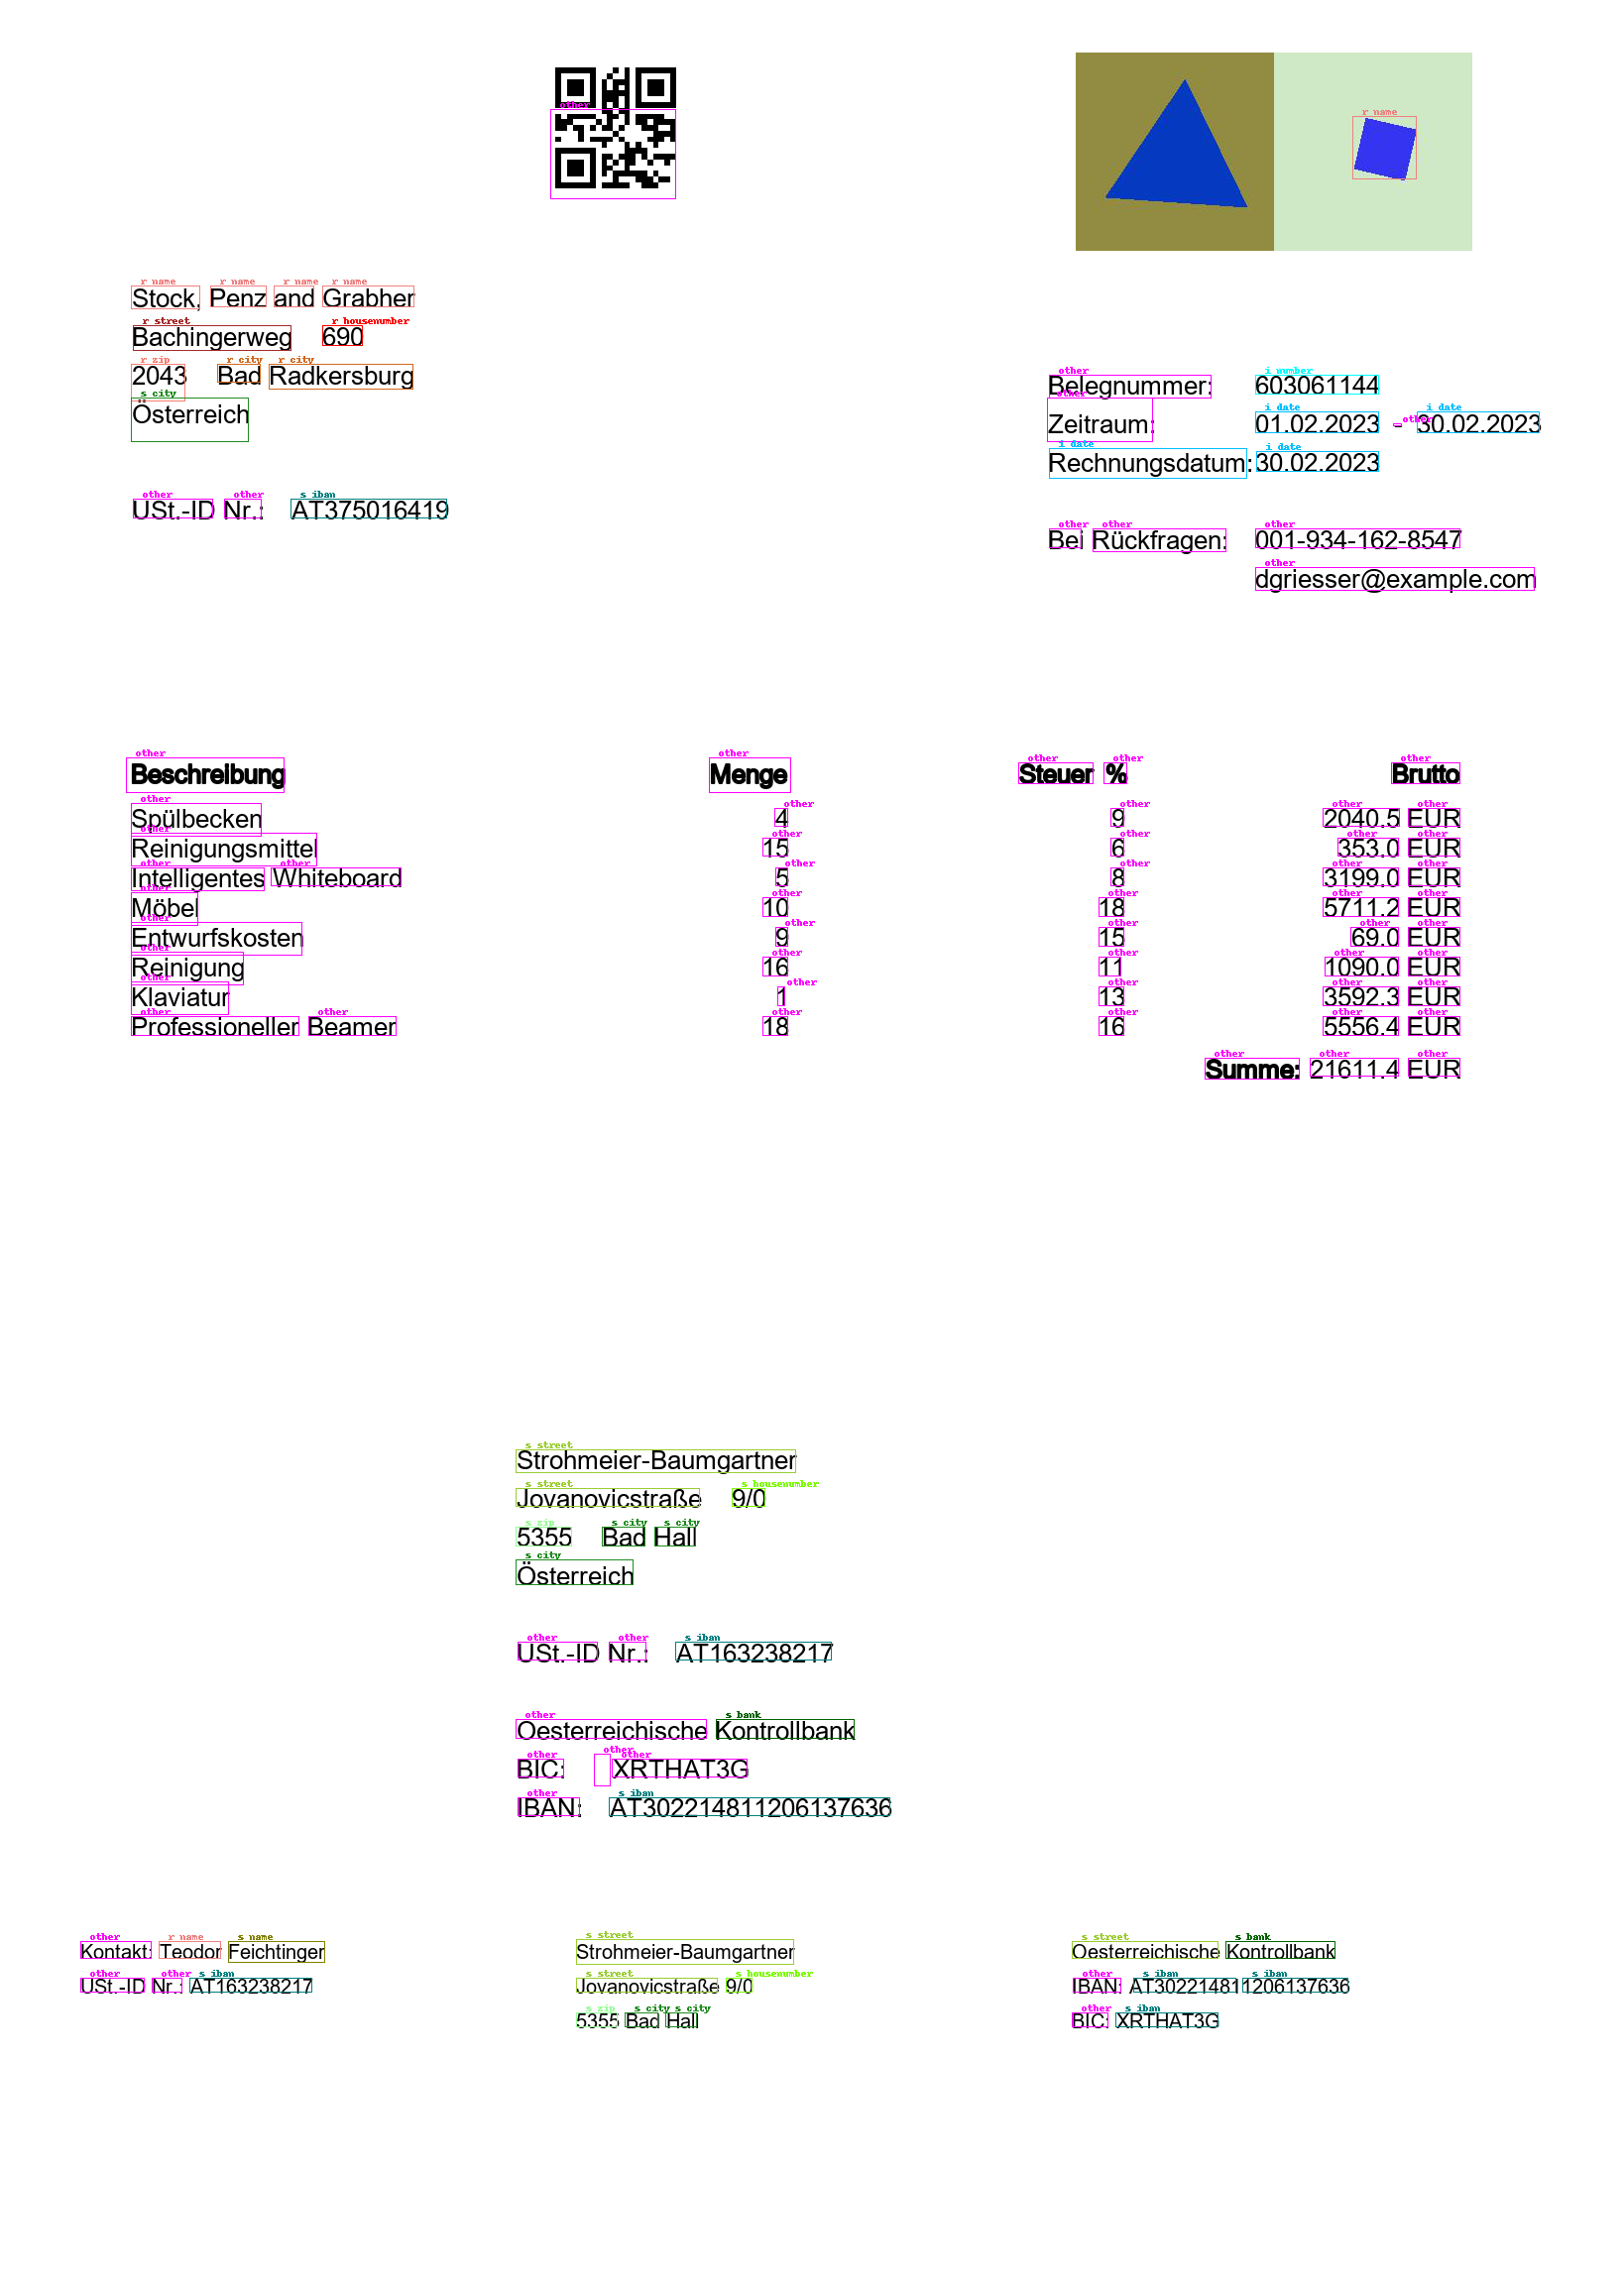

In [9]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(invoice)
font = ImageFont.load_default()
width, height = invoice.size

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

label2color = {
        'r_name':           'lightcoral',
        'r_street':         'brown',
        'r_housenumber':    'red', 
        'r_zip':            'Salmon',
        'r_city':           'chocolate',
        'r_country':        'Sandybrown',
        's_name':           'olive',      
        's_street':         'yellowgreen',
        's_housenumber':    'lawngreen',
        's_zip':            'palegreen',
        's_city':           'forestgreen',
        's_country':        'limegreen',
        's_bank':           'darkgreen',
        's_iban':           'teal',
        'i_number':         'aqua',
        'i_date':           'deepskyblue',
        'i_amount':         'blue',
        'other':            'magenta'
    }


for prediction, box in zip(true_predictions, joinded_bboxes):
    box_normalized = unnormalize_box(box, width, height)
    # Draw the label bounding box and name on the invoice
    draw.rectangle(box_normalized, outline=label2color[prediction])
    draw.text((box_normalized[0] + 10, box_normalized[1] - 10), text=prediction, fill=label2color[prediction], font=font)

invoice